## Import all necessary libraries and modules

In [1]:
import pandas as pd
import numpy as np
import requests as req
import tweepy as tp
import json as js
import re
import matplotlib.pyplot as plt
import math
import re
import os

In [2]:
# dataset files that are already in the current directory
datasets = [ds for ds in list(os.listdir()) if not ds.startswith('.') and not ds.endswith('.ipynb')]
print("Datasets in current directory: ",datasets)

Datasets in current directory:  ['twitter-archive-enhanced.csv', 'image_predictions.tsv', 'tweet_json.txt']


# <center> <font color=blue> DATA GATHERING </font>
---

#### `Data source-01:` 'WeRateDogs' enhanced twitter archive having 2356 tweets

In [3]:
# Loding the csv file 'twitter_archive_enhanced.csv' into a dataframe
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
print("The columns are: \n", list(df_twitter_archive.columns))

The columns are: 
 ['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp', 'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo']


In [4]:
df_twitter_archive.tail(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


#### `Data source-02:`  tweet image predictions file

In [5]:
# Loading the'image_predictions.tsv' file from UDACITY's SERVER using 'requests' library
if 'image_predictions.tsv' in datasets:
    print("Already in the current directory")
    pass
else:
    URL = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
    URL_RESPONSE = req.get(URL)

    # write the content from the url into a tsv file
    with open('image_predictions.tsv','wb') as file:
        file.write(URL_RESPONSE.content)

# Loading the tsv file 'image_predictions.tsv' into a dataframe
df_img_predictions = pd.read_csv('image_predictions.tsv',sep='\t') # '\t' as this is tab separated file

Already in the current directory


In [6]:
print("The columns are: \n", list(df_img_predictions.columns))

The columns are: 
 ['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog']


In [7]:
df_img_predictions.tail(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.07611,False


#### `Data source-03:`  each tweet's retweet count and favorite ("like") count using `tweepy` (for accessing the twitter API)

In [8]:
# Personal API keys, secrets, and tokens which replaced with 'HIDDEN'
# Use your own credentials

API_KEY = 'HIDDEN' 
API_SECRET_KEY = 'HIDDEN'

ACCESS_TOKEN = 'HIDDEN'
ACCESS_TOKEN_SECRET = 'HIDDEN'

In [9]:
# Set the tweepy API 
auth = tp.OAuthHandler(API_KEY, API_SECRET_KEY)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

API = tp.API(auth_handler = auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

In [10]:
# Get the json response from twitter API for each tweet

tweet_ids = df_twitter_archive.tweet_id  # all tweet ids from data source 01

if 'tweet_json.txt' in datasets:
    print("Already in the current directory")
    pass
else:
    with open('tweet_json.txt', 'a', encoding='utf8') as out:
        for tweet_id in tweet_ids:
            try:
                tweet = API.get_status(tweet_id, tweet_mode='extended')
                js.dump(tweet._json, out)
                out.write('\n')
            except:
                bad_tweet_ids.append(int(tweet_id))

Already in the current directory


In [11]:
# Explore the structure of the json response from twitter API for a tweet id
with open('tweet_json.txt', 'r') as json_file:
    for line in json_file:
        for k,v in dict(js.loads(line)).items():
            if k=='user' or k=='entities' or k=='extended_entities':
                continue
            print('\x1b[38;2;255;0;0m {}\x1b[0m'.format(k), end=' ')
            print('value: ',v)
        break

 created_at value:  Tue Aug 01 16:23:56 +0000 2017
 id value:  892420643555336193
 id_str value:  892420643555336193
 full_text value:  This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU
 truncated value:  False
 display_text_range value:  [0, 85]
 source value:  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
 in_reply_to_status_id value:  None
 in_reply_to_status_id_str value:  None
 in_reply_to_user_id value:  None
 in_reply_to_user_id_str value:  None
 in_reply_to_screen_name value:  None
 geo value:  None
 coordinates value:  None
 place value:  None
 contributors value:  None
 is_quote_status value:  False
 retweet_count value:  7739
 favorite_count value:  36356
 favorited value:  False
 retweeted value:  False
 possibly_sensitive value:  False
 possibly_sensitive_appealable value:  False
 lang value:  en


In [12]:
# Load the json responses from the tweet_json.txt file into a list
tweets_json = []
with open('tweet_json.txt', 'r') as json_file:
    for line in json_file:
        tweet_json = js.loads(line)
        tweets_json.append(tweet_json)

In [13]:
print("No of tweets for which I get the response from twitter API: ",len(tweets_json))
print("No of tweets with no response from twitter API: ",2356-len(tweets_json))

No of tweets for which I get the response from twitter API:  2331
No of tweets with no response from twitter API:  25


In [14]:
# Create dataframe for the tweet's json response from the twitter API

# lamda expressions for the columns of the dataframe 
ID = lambda x: x['id']
lang  = lambda x: x['lang']
place = lambda x: x['place']
retweet_count  = lambda x: x['retweet_count']
favorite_count = lambda x: x['favorite_count']
display_text_range = lambda x: x['display_text_range']


df_twitter_api = pd.DataFrame()


df_twitter_api['id'] = list(map(ID, tweets_json)) # apply the lambda function to every json response
df_twitter_api['retweet_count'] = list(map(retweet_count, tweets_json))
df_twitter_api['favorite_count'] = list(map(favorite_count, tweets_json))
df_twitter_api['display_text_range'] = list(map(display_text_range, tweets_json))
df_twitter_api['lang'] = list(map(lang, tweets_json))
df_twitter_api['place'] = list(map(place, tweets_json))

In [15]:
print("The columns are: \n", list(df_twitter_api.columns))

The columns are: 
 ['id', 'retweet_count', 'favorite_count', 'display_text_range', 'lang', 'place']


In [16]:
df_twitter_api.tail(1)

,id,retweet_count,favorite_count,display_text_range,lang,place
2330,666020888022790149,465,2424,"[0, 131]",en,None


# <center> <font color=blue> ASSESSING DATA  </font> </center>
<center> Visually and Programmatically </center>

---

#### Need to detect and document at least `8 quality issues and 2 tidiness issues`

#### <font color=blue> I only want original ratings (no retweets) that have images as it is said in project motivation section. 


Three dataframes:

- `df_twitter_archive` has the tweet's text, rating, dog name, dog category etc.


- `df_img_predictions` has the prediction results of a neural network(nn) trying to identify the dog breed in a tweet's picture.



- `df_twitter_api` has retweet, favorite counts, place, language.


Here, I am inspecting these 3 dataframes for two things: 

- Data quality issues and
- Tidiness issues

**Quality Issues** means content issues like missing, duplicate, or incorrect data while **tidiness issues** means structural issues.

---
There are four dimensions of data quality assessment.

**Completeness** ~ Are there any missing data in specific rows or columns? 

**Validity** ~ Are there any records not correct due to any reason? 

**Accuracy** ~ Are there any extreme data or unusual data? 

**Consistency** ~ Are they keep the consistence of scale standard or data type?

### <center> <font color=brown> Inspecting  `df_twitter_archive` dataframe

In [17]:
df_twitter_archive.info() # 2356 rows and 17 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [18]:
df_twitter_archive.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

### <font color=blue> Observation: 
- Some columns are not null but have less than 2356 entries which reflects that there missing values in those columns. e.g. *in_reply_to_status_id* and *in_reply_to_user_id* have only 78 values which means there are many missing values in these two columns.**[Completeness issue]**
    

- 'retweeted_status_id' has 181 entries which means these are not original tweets.


- Some columns are actually not necessary for my analysis purpose. e.g. retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp. **[Completeness issue]**


- Wrong data type. e.g. timestamp column doesn't have the data type "datetime' **[Consistency issue]**


- I need those tweets having images. But there are some tweets having no image which I find from the 'expanded_urls' column. There are 2297 entries in this columns. So, missing images for 59 tweets **[Completeness issue]**


In [19]:
df_twitter_archive.describe() 

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


### <font color=blue> Observation: 
- The max value for the column 'rating_numerator' is 1776 and mean value is 13.13 which means the max value is an outlier. The rating 1776 is incorrect. **[Accuracy issue]**

- The value for the column 'rating_denominator' should be always 10. But I see that the mean is 10.46 and the max value is 170 which means there are some wrong entries in this column. **[Accuracy issue]**

In [20]:
# Explore the distribution of values for the column 'rating_denominator'
df_twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [21]:
# Explore the distribution of values for the column 'rating_numerator'
df_twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [22]:
# INSPECT VISUALLY
df_twitter_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1825,676470639084101634,NaN,NaN,2015-12-14 18:35:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Three generations of pupper. 11/10 for all htt...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/676470639...,11,10,None,None,None,pupper,None
483,814986499976527872,NaN,NaN,2016-12-31 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cooper. Someone attacked him with a sh...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/814986499...,11,10,Cooper,None,None,pupper,None
637,793286476301799424,NaN,NaN,2016-11-01 03:00:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Moreton. He's the Good Boy Who Lived. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/793286476...,13,10,Moreton,None,None,None,None
2048,671511350426865664,NaN,NaN,2015-12-01 02:09:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Hammond. He's just a wee lil pup....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671511350...,8,10,Hammond,None,None,None,None
1744,679158373988876288,NaN,NaN,2015-12-22 04:35:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Rubio. He has too much skin. 11/10 htt...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/679158373...,11,10,Rubio,None,None,None,None


In [23]:
pd.set_option('display.max_colwidth', -1) # for seeing the entire contents of a column
print(str(df_twitter_archive.head(1).text))

0    This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU
Name: text, dtype: object


In [24]:
print(str(df_twitter_archive.head(1).source))

0    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
Name: source, dtype: object


In [25]:
df_twitter_archive.name.str.islower().sum()

109

In [26]:
df_twitter_archive.name.str.isupper().sum()

2

In [27]:
print(df_twitter_archive.name.value_counts())

None       745
a          55 
Charlie    12 
Cooper     11 
Lucy       11 
           .. 
Comet      1  
Andy       1  
Ferg       1  
Gustav     1  
Snicku     1  
Name: name, Length: 957, dtype: int64


In [28]:
print(df_twitter_archive.source.value_counts())

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                        91  
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                     33  
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>    11  
Name: source, dtype: int64


### <font color=blue> Observation: 

- The format of the 'source' columns is not human readable due to the anchor tag. From the value distribution, I find that there are only 4 types of sources : 
    - Twitter for iPhone
    - Vine - Make a Scene
    - Twitter Web Client and 
    - TweetDeck.
    

- The 'name' column has some incorrect names. e.g. 'a' for 55 times ! Also some names start with capital letter (may be these are correct name) while some start with small letter (may be these are incorrect name) **[Consistency issue]**


- There are 4 columns (doggo, floofer, pupper, puppo) for dog stage which are actually values of the dog stage. So these 4 columns can be replaced with a single column. **[Tidiness issue]**


### <center> <font color=brown> Inspecting  `df_img_predictions` dataframe

In [29]:
df_img_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


### <font color=blue> Observation: 
- This dataframe has 2075 entris but the previous data frame 'df_twitter_archive' has 2356 entries. That means in this dataframe some tweets are missing. **[Completeness issue]**
    
    
- Some columns are unnecessary for my purpose as I only need the most confident prediction of the dog breed.


In [30]:
df_img_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [31]:
df_img_predictions.tail(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [32]:
df_img_predictions.p1.value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke              89 
Chihuahua             83 
pug                   57 
                      .. 
maze                  1  
water_buffalo         1  
lorikeet              1  
microphone            1  
cup                   1  
Name: p1, Length: 378, dtype: int64

In [33]:
df_img_predictions.p2.value_counts()

Labrador_retriever    104
golden_retriever      92 
Cardigan              73 
Chihuahua             44 
Pomeranian            42 
                      .. 
accordion             1  
komondor              1  
spotlight             1  
iPod                  1  
comic_book            1  
Name: p2, Length: 405, dtype: int64

In [34]:
df_img_predictions.p3.value_counts()

Labrador_retriever    79
Chihuahua             58
golden_retriever      48
Eskimo_dog            38
kelpie                35
                      ..
orangutan             1 
barber_chair          1 
maze                  1 
boathouse             1 
great_grey_owl        1 
Name: p3, Length: 408, dtype: int64

### <font color=blue> Observation: 

- Some predctions are wrong like in some images they predict other objects instead of the dog. In the tweet id '892420643555336193' I find that there is a dog and a bagel. But all three predictions are wrong.

### <center> <font color=brown> Inspecting `df_twitter_api` dataframe
    

In [35]:
df_twitter_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 6 columns):
id                    2331 non-null int64
retweet_count         2331 non-null int64
favorite_count        2331 non-null int64
display_text_range    2331 non-null object
lang                  2331 non-null object
place                 1 non-null object
dtypes: int64(3), object(3)
memory usage: 109.4+ KB


### <font color=blue> Observation: 
- This dataframe has 2331 entries. But there are 2356 entries in the archive tweets file. There are 25 missing tweets for which I have no retweet count and favorite count.
    
- The place columns has only 1 entry so it is not useful for our analysis purpose.

- I have total 3 dataframes which have one common column tweet id (or id). So, I can merge three dataframes into a single dataframe. **[Tidiness issue]**

In [36]:
df_twitter_api.describe()

,id,retweet_count,favorite_count
count,2.331000e+03,2331.000000,2331.000000
mean,7.419079e+17,2716.172887,7594.350922
std,6.823170e+16,4594.144209,11783.800814
min,6.660209e+17,1.000000,0.000000
25%,6.782670e+17,548.500000,1324.000000
50%,7.182469e+17,1275.000000,3307.000000
75%,7.986692e+17,3155.500000,9304.500000
max,8.924206e+17,78205.000000,156950.000000


In [37]:
df_twitter_api.sample(5)

,id,retweet_count,favorite_count,display_text_range,lang,place
620,793271401113350145,2460,8923,"[0, 118]",en,None
672,787397959788929025,2911,11137,"[0, 107]",en,None
1447,693993230313091072,402,1881,"[0, 125]",en,None
467,814986499976527872,1310,7814,"[0, 93]",en,None
1780,676942428000112642,739,2050,"[0, 76]",en,None


## <center> Summary of my data assessment :

###  <center> <font color=darkorange> Quality Issues: 

**Issue 01:** I need those tweets having images. But there are some tweets having no image which I find from the <font color=blue>expanded_urls</font> column. There are 2297 entries in this column. So, missing images for 59 tweets. Any tweets without images should be removed.

**Issue 02:** The datatype of the column <font color=blue>timestamp</font> is not correct.

**Issue 03:** <font color=blue>retweeted_status_id</font> has 181 entries which means these 181 tweets are retweets (not original tweets). I should remove these tweets from my analysis.


**Issue 04:** Some columns are actually not necessary for analysis purpose. e.g. retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp. I prefer to remove these columns


**Issue 05:** The value for the column <font color=blue>rating_denominator</font> should be always 10. But I see that the mean is 10.46 and the max value is 170 which means there are some wrong entries in this column

**Issue 06:** The max value for the column <font color=blue>rating_numerator</font> is 1776 and mean value is 13.13 which means the max value is an outlier. The rating 1776 is incorrect. So, the column has some incorrect values.

**Issue 07:** Make the contents of the column <font color=blue>source</font> human readable by change the long url links to specific words which are part of the anchor tag.  From the value distribution, I find that there are only 4 types of sources :
- Twitter for iPhone
- Vine - Make a Scene
- Twitter Web Client and
- TweetDeck.

**Issue 08:** The <font color=blue>name</font> column has some incorrect names. e.g. 'a' for 55 times ! 

**Issue 09:** Also some names start with capital letter while some start with small letter in the column <font color=blue>name</font>.

**Issue 10:** Column names are not clear and straightforward in `df_img_predictions` dataframe such as p1,p2.

**Issue 11:** Prediction of dog breeds involve both uppercase and lowercase for the first letter. e.g. 
Labrador_retriever, golden_retriever etc.

### <center>  <font color=darkorange> Tidiness Issues: 

**Issue 01:** There are 4 columns (doggo, floofer, pupper, puppo) for dog stage which are actually values of the dog stage. So these 4 columns can be replaced with a single column - **dog_stage**

**Issue 02:** I have total 3 dataframes which have one common column tweet id (or id). So, I can merge three dataframes into a single dataframe.

# <center> <font color=blue> DATA CLEANING</font>

In [38]:
# create copies of the dataframes for cleaning purpose
df_1 = df_twitter_archive.copy()
df_2 = df_img_predictions.copy()
df_3 = df_twitter_api.copy()

## <font color=brown> Tidiness- Issue 01 : </font>

#### Define

Create a new column `dog_stage`, remove individual dog stage columns and fill the empty value with NaN.

#### Code

In [39]:
stages = ['doggo','pupper', 'floofer', 'puppo' ]
for stage in stages:
    df_1[stage] = df_1[stage].replace('None','')

In [40]:
df_1['dog_stage'] = df_1['doggo'].str.cat(df_1[['pupper', 'floofer','puppo']].astype(str),sep='')

In [41]:
df_1.head(100).tail(3)[['tweet_id','doggo','pupper', 'floofer', 'puppo','dog_stage']]

,tweet_id,doggo,pupper,floofer,puppo,dog_stage
97,873337748698140672,,pupper,,,pupper
98,873213775632977920,,pupper,,,pupper
99,872967104147763200,doggo,,,,doggo


In [42]:
df_1 = df_1.drop(stages, axis = 1) # drop the 4 columns
df_1['dog_stage'] = df_1['dog_stage'].replace('', np.nan)

#### Test

In [43]:
df_1.head(100).tail(3)[['tweet_id','dog_stage']]

,tweet_id,dog_stage
97,873337748698140672,pupper
98,873213775632977920,pupper
99,872967104147763200,doggo


## <font color=brown> Tidiness- Issue 02 : </font>

#### Define 

Merge 3 dataframes into a single master dataframe using the common column twitter_id (or id)

#### Code

In [44]:
print("No of rows in dataframe 01: ",df_1.tweet_id.count()) # df_twitter_archive_clean
print("No of rows in dataframe 02: ",df_2.tweet_id.count()) # df_img_predictions_clean
print("No of rows in dataframe 03: ",df_3.id.count()) # df_twitter_api_clean

No of rows in dataframe 01:  2356
No of rows in dataframe 02:  2075
No of rows in dataframe 03:  2331


In [45]:
df_merged = df_1.merge(df_2, on='tweet_id', how='inner')
print("No of rows after merging: ",df_merged.tweet_id.count())

df_merged = pd.merge(left=df_merged, right=df_3, left_on='tweet_id', right_on='id', how='inner')
print("No of rows after merging: ",df_merged.tweet_id.count())

df_merged = df_merged.drop('id', axis=1)

No of rows after merging:  2075
No of rows after merging:  2059


#### Test

In [46]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 2058
Data columns (total 30 columns):
tweet_id                      2059 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2059 non-null object
source                        2059 non-null object
text                          2059 non-null object
retweeted_status_id           72 non-null float64
retweeted_status_user_id      72 non-null float64
retweeted_status_timestamp    72 non-null object
expanded_urls                 2059 non-null object
rating_numerator              2059 non-null int64
rating_denominator            2059 non-null int64
name                          2059 non-null object
dog_stage                     318 non-null object
jpg_url                       2059 non-null object
img_num                       2059 non-null int64
p1                            2059 non-null object
p1_conf                       2059 no

## <font color=brown> Quality- Issue 01 : </font>

#### Define

Remove the tweets where there are no images ('expanded_urls' column has 'NaN' value). 

#### Code

In [47]:
df_merged = df_merged.dropna(subset=['expanded_urls'])

#### Test

In [48]:
df_merged.expanded_urls.isnull().sum()

0

In [49]:
df_merged.expanded_urls.count()

2059

## <font color=brown> Quality- Issue 02 : </font>

#### Define

Update the datatype of 'timestamp' to datetime

#### Code

In [50]:
df_merged['timestamp'] = pd.to_datetime(df_merged['timestamp'])

#### Test

In [51]:
df_merged['timestamp'].head(2)

0   2017-08-01 16:23:56+00:00
1   2017-08-01 00:17:27+00:00
Name: timestamp, dtype: datetime64[ns, UTC]

## <font color=brown> Quality- Issue 03 : </font>

#### Define

Remove the retweets

#### Code

In [52]:
df_merged = df_merged[df_merged['retweeted_status_id'].isnull()]

#### Test

In [53]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2058
Data columns (total 30 columns):
tweet_id                      1987 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     1987 non-null datetime64[ns, UTC]
source                        1987 non-null object
text                          1987 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1987 non-null object
rating_numerator              1987 non-null int64
rating_denominator            1987 non-null int64
name                          1987 non-null object
dog_stage                     305 non-null object
jpg_url                       1987 non-null object
img_num                       1987 non-null int64
p1                            1987 non-null object
p1_conf                    

## <font color=brown> Quality- Issue 04 : </font>

#### Define

Remove all unnecessary columns. For example: 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'in_reply_to_status_id', 'in_reply_to_user_id', 'in_reply_to_user_id.

'retweeted_status_id' is not need any more as I already removed the retweets using this column.

#### Code

In [54]:
all_col = list(df_merged.columns)
print("Columns before removing unnecessary columns: ",len(all_col))

columns = ['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp','in_reply_to_status_id','in_reply_to_user_id']

for col in columns:
    if col in all_col:
        df_merged = df_merged.drop(col, axis=1)

Columns before removing unnecessary columns:  30


#### Test

In [55]:
print(list(df_merged.columns))
print("Columns after removing unnecessary columns: ",len(list(df_merged.columns)))

['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'name', 'dog_stage', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'retweet_count', 'favorite_count', 'display_text_range', 'lang', 'place']
Columns after removing unnecessary columns:  25


## <font color=brown> Quality- Issue 05 : </font>

#### Define

The value for the column rating_denominator should be always 10. But I see that the mean is 10.46 and the max value is 170 which means there are some wrong entries in this column. Correct the incorrect values based on the corresponding text of the tweet.

#### Code

In [56]:
df_merged.rating_denominator.value_counts()

10     1969
50     3   
80     2   
11     2   
170    1   
150    1   
130    1   
120    1   
110    1   
90     1   
70     1   
40     1   
20     1   
7      1   
2      1   
Name: rating_denominator, dtype: int64

In [57]:
df_temp = df_merged[df_merged['rating_denominator'] != 10]
df_temp.tweet_id.count() # no of tweets having wrong denominator (rating)

18

In [58]:
df_temp.style.hide_index()
df_temp[['tweet_id','text','rating_numerator','rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
336,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
406,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
722,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
863,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
911,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
954,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
988,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50
1009,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90
1034,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80
1052,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45,50


In [59]:
tweet_ids = [740373189193256964, 722974582966214656, 716439118184652801, 682962037429899265, 666287406224695296]

In [60]:
for i in tweet_ids:
    df_merged.loc[ df_merged.tweet_id == i , ['rating_denominator']] = 10

#### Test

In [61]:
df_merged.loc[df_merged.tweet_id == 740373189193256964]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,jpg_url,...,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,display_text_range,lang,place
863,740373189193256964,2016-06-08 02:41:38+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ","https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,10,None,NaN,https://pbs.twimg.com/media/CkZVdJ6WYAAXZ5A.jpg,...,0.101286,True,Labrador_retriever,0.023785,True,13328,35066,"[0, 116]",en,None


## <font color=brown> Quality- Issue 06 : </font>

#### Define

Correct the 'rating_numerator' values from the tweet text

#### Code

In [62]:
df_merged.loc[df_merged.tweet_id == 740373189193256964, ['rating_numerator']] = 14
df_merged.loc[df_merged.tweet_id == 722974582966214656, ['rating_numerator']] = 13
df_merged.loc[df_merged.tweet_id == 716439118184652801, ['rating_numerator']] = 11
df_merged.loc[df_merged.tweet_id == 682962037429899265, ['rating_numerator']] = 10
df_merged.loc[df_merged.tweet_id == 666287406224695296, ['rating_numerator']] = 9

#### Test

In [63]:
df_merged.loc[df_merged.tweet_id == 740373189193256964]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,jpg_url,...,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,display_text_range,lang,place
863,740373189193256964,2016-06-08 02:41:38+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ","https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",14,10,None,NaN,https://pbs.twimg.com/media/CkZVdJ6WYAAXZ5A.jpg,...,0.101286,True,Labrador_retriever,0.023785,True,13328,35066,"[0, 116]",en,None


## <font color=brown> Quality- Issue 07 : </font>

#### Define

Make the contents of the column `source` human readable by change the long url links to specific words which are part of the anchor tag.

#### Code

In [64]:
df_merged['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1949
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                     28  
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>    10  
Name: source, dtype: int64

In [65]:
v1 = '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'
r1 = 'Twitter for iPhone'

v2 = '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>'
r2 = 'Twitter Web Client'

v3 = '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'
r3 = 'TweetDeck'

df_merged['source'] = df_merged['source'].replace(v1,r1)
df_merged['source'] = df_merged['source'].replace(v2,r2)
df_merged['source'] = df_merged['source'].replace(v3,r3)

#### Test

In [66]:
df_merged['source'].value_counts()

Twitter for iPhone    1949
Twitter Web Client    28  
TweetDeck             10  
Name: source, dtype: int64

## <font color=brown> Quality- Issue 08 : </font>

#### Define

Some dog names are incorrect. Replace the frequent incorrect names with 'None'. 

#### Code

In [67]:
df_merged.name.value_counts().count() # different name count

934

In [68]:
df_merged.name.value_counts().head(20)

None       546
a          55 
Charlie    10 
Cooper     10 
Oliver     10 
Tucker     9  
Lucy       9  
Penny      9  
Winston    8  
Sadie      8  
the        7  
Toby       7  
Lola       7  
Daisy      7  
Stanley    6  
Koda       6  
Bo         6  
an         6  
Jax        6  
Bella      6  
Name: name, dtype: int64

In [69]:
df_merged.name.value_counts().head(50).tail(10)

Winnie     4
Maggie     4
Phil       4
Duke       4
Bentley    4
Sophie     4
Jack       4
Clark      4
Archie     4
Chip       4
Name: name, dtype: int64

In [70]:
wrong_name = ['a','an','the','such','just','one','getting','light','this',
              'incredibly','not','infuriating','by','my','his'] # find this name by manual inspection

for n in wrong_name:
    df_merged['name'].replace(n, 'None', inplace=True)

#### Test

In [71]:
df_merged.name.value_counts().head(5)

None       632
Oliver     10 
Charlie    10 
Cooper     10 
Penny      9  
Name: name, dtype: int64

## <font color=brown> Quality- Issue 09 : </font>

#### Define

Capitalize the name of the dog for consistency

#### Code

In [72]:
df_merged['name'].str.islower().sum()

12

In [73]:
df_merged['name'] = df_merged.name.str.capitalize()

#### Test

In [74]:
df_merged['name'].str.islower().sum()

0

## <font color=brown> Quality- Issue 10 : </font>

#### Define

Change names of the columns from 'df_img_predictions' datframe   for better readability

#### Code

In [75]:
df_merged.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'dog_stage',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'retweet_count', 'favorite_count',
       'display_text_range', 'lang', 'place'],
      dtype='object')

In [76]:
df_merged.rename(columns={'p1':'algo_01_prediction', 'p1_conf': 'algo_01_confidence', 'p1_dog': 'algo_01_dog',
                          'p2':'algo_02_prediction', 'p2_conf': 'algo_02_confidence', 'p2_dog': 'algo_02_dog',
                          'p3':'algo_03_prediction', 'p3_conf': 'algo_03_confidence', 'p3_dog': 'algo_03_dog'}, 
                           inplace = True)


#### Test

In [77]:
df_merged.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'dog_stage',
       'jpg_url', 'img_num', 'algo_01_prediction', 'algo_01_confidence',
       'algo_01_dog', 'algo_02_prediction', 'algo_02_confidence',
       'algo_02_dog', 'algo_03_prediction', 'algo_03_confidence',
       'algo_03_dog', 'retweet_count', 'favorite_count', 'display_text_range',
       'lang', 'place'],
      dtype='object')

## <font color=brown> Quality- Issue 11 : </font>

#### Define

Prediction of dog breeds involve both uppercase and lowercase for the first letter. e.g. 
Labrador_retriever, golden_retriever etc. Capitalize the dog breed  predictions.

#### Code

In [78]:
df_merged['algo_01_prediction'] = df_merged.algo_01_prediction.str.capitalize()
df_merged['algo_02_prediction'] = df_merged.algo_02_prediction.str.capitalize()
df_merged['algo_03_prediction'] = df_merged.algo_03_prediction.str.capitalize()

#### Test

In [79]:
df_merged[['tweet_id','algo_01_prediction','algo_02_prediction','algo_03_prediction']].head(5)

,tweet_id,algo_01_prediction,algo_02_prediction,algo_03_prediction
0,892420643555336193,Orange,Bagel,Banana
1,892177421306343426,Chihuahua,Pekinese,Papillon
2,891815181378084864,Chihuahua,Malamute,Kelpie
3,891689557279858688,Paper_towel,Labrador_retriever,Spatula
4,891327558926688256,Basset,English_springer,German_short-haired_pointer


In [80]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2058
Data columns (total 25 columns):
tweet_id              1987 non-null int64
timestamp             1987 non-null datetime64[ns, UTC]
source                1987 non-null object
text                  1987 non-null object
expanded_urls         1987 non-null object
rating_numerator      1987 non-null int64
rating_denominator    1987 non-null int64
name                  1987 non-null object
dog_stage             305 non-null object
jpg_url               1987 non-null object
img_num               1987 non-null int64
algo_01_prediction    1987 non-null object
algo_01_confidence    1987 non-null float64
algo_01_dog           1987 non-null bool
algo_02_prediction    1987 non-null object
algo_02_confidence    1987 non-null float64
algo_02_dog           1987 non-null bool
algo_03_prediction    1987 non-null object
algo_03_confidence    1987 non-null float64
algo_03_dog           1987 non-null bool
retweet_count         1987 n

# <center> <font color=blue> DATA STORING</font>

In [81]:
df_merged.to_csv('twitter_archive_master.csv', encoding='utf-8')

# <center> <font color=blue> ANALYZE & VISUALIZE </font>

## Distribution of source 

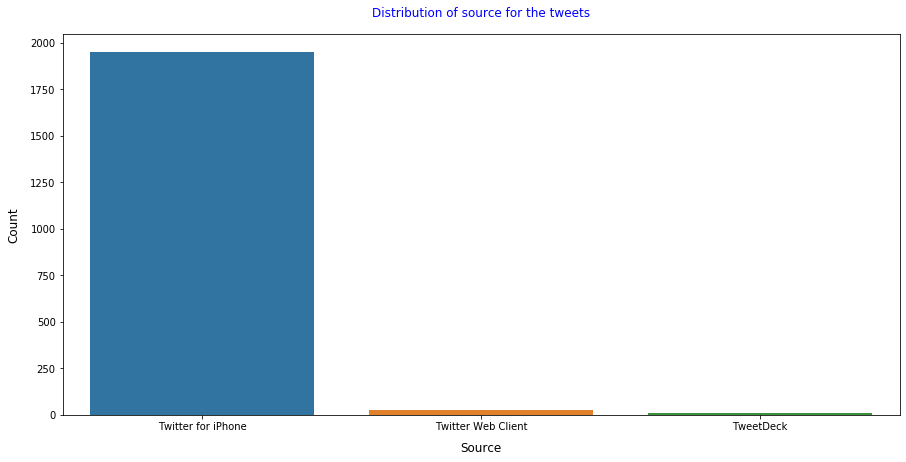

In [104]:
import seaborn as sb

plt.figure(figsize=[15,7])

sb.countplot(data = df_merged, x ='source')

plt.title("Distribution of source for the tweets", fontsize=12, y=1.03, color='blue');
plt.xlabel('Source',fontsize=12, labelpad=10);
plt.ylabel('Count', fontsize=12, labelpad=10);





This plot above shows the distribution of source. We can see that the dominate source of tweets is from iPhone twitter app.

## Distribution of dog stages 

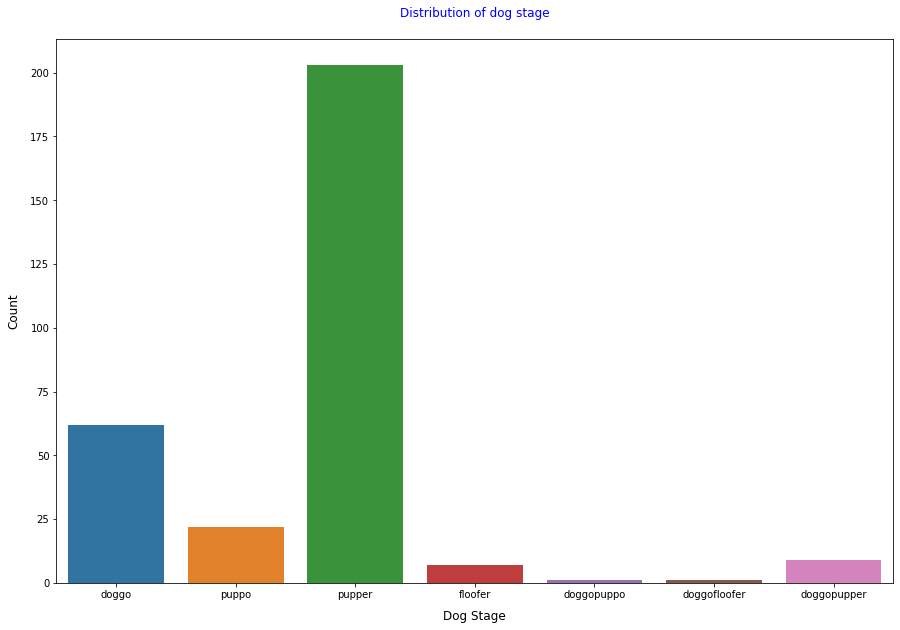

In [119]:
plt.figure(figsize=[15,10])

sb.countplot(data = df_merged, x ='dog_stage')

plt.title("Distribution of dog stage", fontsize=12, y=1.03, color='blue');
plt.xlabel('Dog Stage',fontsize=12, labelpad=10);
plt.ylabel('Count', fontsize=12, labelpad=10);

The distribution of dog stage shows that **pupper** (small younger dog) is the most popular dog stage, followed by ‘doggo’ and ‘puppo’. As there are many missing values in the 'dog_stage' column so this distribution may not reflect the true distribution. Also I find that there were some errors in the enhanced twitter archive data. For some dog there were more than one dog stage. As a result we will see in the above graph 3 weird bar : doggopuppo, doggoflooper, doggopupper.

## Correlation between Retweet count and Favorite count

In [120]:
df_merged.corr(method='pearson')

,tweet_id,rating_numerator,rating_denominator,img_num,algo_01_confidence,algo_01_dog,algo_02_confidence,algo_02_dog,algo_03_confidence,algo_03_dog,retweet_count,favorite_count
tweet_id,1.000000,0.023622,-0.022035,0.213043,0.104599,0.119122,-0.002380,0.122315,-0.046915,0.095984,0.382808,0.610384
rating_numerator,0.023622,1.000000,0.197406,-0.000423,-0.008757,-0.029359,-0.021767,-0.034728,-0.006148,-0.029568,0.018678,0.016251
rating_denominator,-0.022035,0.197406,1.000000,-0.003302,-0.000664,-0.000849,-0.040742,-0.002330,-0.005419,0.003171,-0.019449,-0.026470
img_num,0.213043,-0.000423,-0.003302,1.000000,0.204491,0.032942,-0.156397,0.052641,-0.141630,0.063045,0.103739,0.129584
algo_01_confidence,0.104599,-0.008757,-0.000664,0.204491,1.000000,0.125900,-0.509641,0.141271,-0.707513,0.118262,0.047648,0.070318
algo_01_dog,0.119122,-0.029359,-0.000849,0.032942,0.125900,1.000000,0.109907,0.635259,0.047285,0.558037,0.002700,0.043370
algo_02_confidence,-0.002380,-0.021767,-0.040742,-0.156397,-0.509641,0.109907,1.000000,0.096701,0.481779,0.064263,-0.014151,-0.016385
algo_02_dog,0.122315,-0.034728,-0.002330,0.052641,0.141271,0.635259,0.096701,1.000000,0.035010,0.554087,0.012619,0.051829
algo_03_confidence,-0.046915,-0.006148,-0.005419,-0.141630,-0.707513,0.047285,0.481779,0.035010,1.000000,0.034282,-0.038838,-0.046984
algo_03_dog,0.095984,-0.029568,0.003171,0.063045,0.118262,0.558037,0.064263,0.554087,0.034282,1.000000,0.006365,0.034639


The r^2 value between retweet_count and favorite_cout is **0.929039** which indicates strong positive correlation.

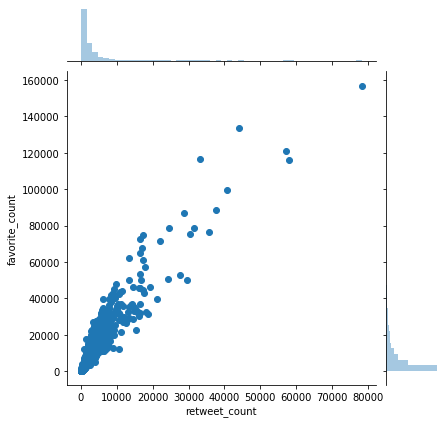

In [147]:
plt.rcParams["figure.figsize"] = [12, 9]
sb.jointplot(x="retweet_count", y="favorite_count", data=df_merged)

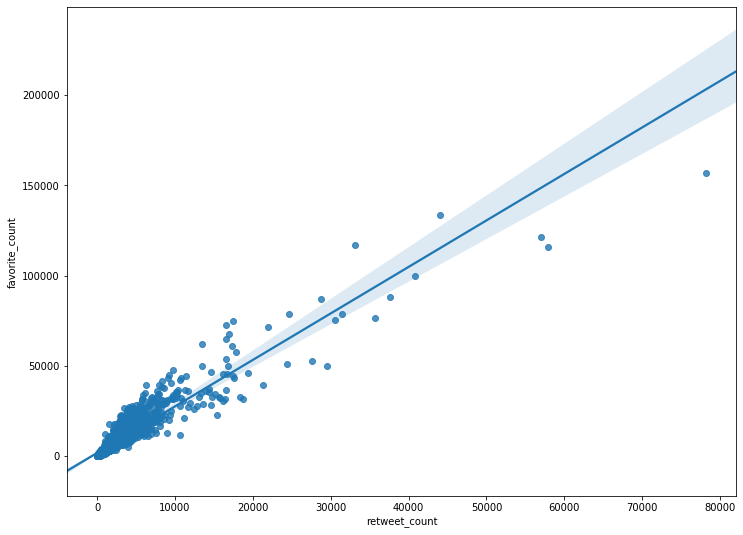

In [146]:
sb.regplot(x="retweet_count", y="favorite_count", data=df_merged)

## Popular dog name

Text(0.5, 0, 'Number of Dogs')

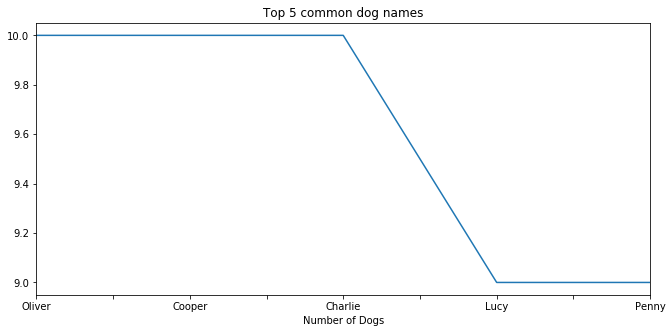

In [132]:
df_merged.name.value_counts()[1:6].plot(figsize=(11,5), title='Top 5 common dog names').set_xlabel("Number of Dogs")

We can see that most popular names are - Oliver, Cooper and Charlie

## Tweet trend over year

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='line')` instead of `Series.plot('line',)`.
  This is separate from the ipykernel package so we can avoid doing imports until


(0, 384.2)

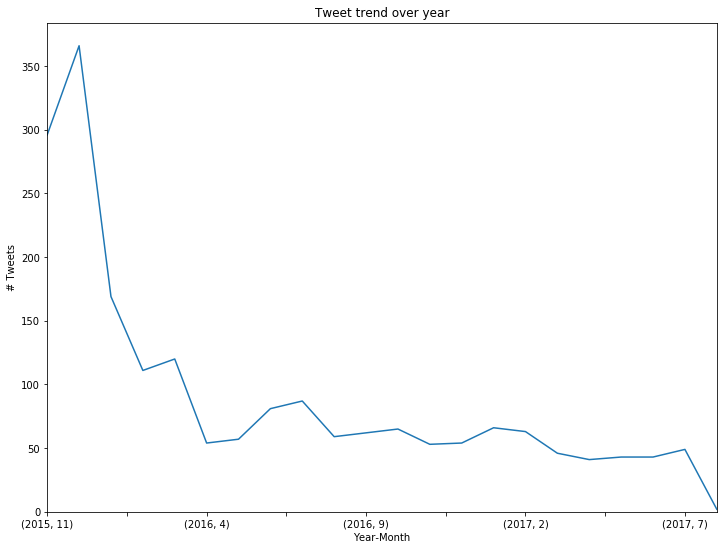

In [144]:
d = df_merged.tweet_id.groupby([df_merged["timestamp"].dt.year, df_merged["timestamp"].dt.month]).count()

ax = d.plot('line', title='Tweet trend over year')
ax.set_xlabel("Year-Month")
ax.set_ylabel("# Tweets")
ax.set_ylim(0, )



From the above plot, we find that the tweet trend in decreasing over the time. The tweeting trend was highest in the beginning of the year 2016.